# "The Titanic has a Leak"

> "We will explore a source of data leakage in the popular Titanic competition on Kaggle: Passengers traveling together have similar survival outcomes and this correlation can be used to make predictions for the test set in a way that wouldn't be possible in reality. To prevent the leakage we implement a leak-proof cross-validation. We compare the accuracy of an XGBoost classifier to various baselines to investigate which role, if any, the leakage is playing in the predictions of our classifier."
- toc: True

In [1]:
#collapse-hide
from collections import defaultdict
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_validate, GridSearchCV, StratifiedKFold, StratifiedGroupKFold
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OrdinalEncoder
import xgboost as xgb
import networkx as nx
import matplotlib.pyplot as plt

## What is leakage?

Training a machine learning model to make predictions is tricky (especially about the future!). One of the main issues is [overfitting](https://en.wikipedia.org/wiki/Overfitting): If left unchecked, models will tend to fit the training data too specifically in a way that doesn't actually generalize to "future data".

This is why we always set aside a subset of the data (the **test set**) to evaluate the model predictions. The model never gets to see the test data during training, to simulate new data like the data the model will have to deal with when in real deployment. At first this seems like a foolproof method to gauge how well the model will do in practice, assuming that the "future data" in the context the model needs to operate arises from the same probability distribution as our current data (that is a whole other issue, see [data drift](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-monitor-datasets?tabs=python)).

However, in practice there might be **unintended correlations** between the test set and the data we used to train the model (the **training set**). Those correlations might allow us to make predictions based on information which we wouldn't actually have access to at prediction time in reality. We call this phenomenon **data leakage**, because "future" information is accidentally leaking from the test set to the training set. This can lead to dramatically overestimating the true model performance. Even worse, the model could end up mostly relying on the leakage for predictions, to the detriment of legitimate signals. This would make it essentially useless in a real deployment.

This somewhat abstract description will become clearer once we look at a specific instance of leakage.

## Where is the leakage?
In the case of the famous **Titanic** [competition](https://www.kaggle.com/c/titanic) there is a major source of information leakage. **Groups of women and children** traveling together tend to either all live or all die, simply because they tended to stay together. Women and children were famously prioritized on the lifeboats, while adult men were separated from their families.

This is an instance of data leakage because we wouldn't have known which families were going to survive before the Titanic sank, yet it provides us with a lot of information on passenger survival in our data. Strictly speaking, it is open to debate what exactly constitutes leakage in a one-time event such as in the Titanic disaster. However, if we imagine having to make a prediction about another ship sinking in similar circumstances, it seems unreasonable to assume that we would have information on which families would survive *beyond the information on which passengers would survive*. In contrast to survival per passenger class, for instance, family survival is seems to be subject to random events in a way that is not generalizable (what could be called random noise).

## Why does the leakage matter?

I am not the first one to point out that family survival is a major predictor of individual passenger survival. As far as I know, however, the extent and importance of the leakage has not been thoroughly investigated yet.

There is no doubt that using the leakage gives an important advantage in the Kaggle Titanic competition. Most passenger groups (which we will specify below) have in fact been separated in the train-test split. This is not a particular characteristic of the Kaggle test set. Instead, it is statistically a near-certainty given the number of groups and the group sizes, as long as the test set makes up a third of the data.

We can distinguish three ways in which the leakage has been used on the Kaggle competition over the years:
- [Chris Deotte](https://www.kaggle.com/code/cdeotte/titanic-using-name-only-0-81818/notebook) and others have already observed that one can get very good results (better than many sophisticated approaches) just by making predictions with a very simple rule **using family survival directly** (but not explicitly identifying it as an example of data leakage, to the best of my knowledge). The rule is the following: Just predict that all males die and all females live, except for boys whose family survived (who are predicted to live instead) and females whose family died (who are predicted to die instead). We will implement this model bellow and compare its accuracy with other approaches.
- People like [Erik Bruin](https://www.kaggle.com/code/erikbruin/titanic-2nd-degree-families-and-majority-voting/report) have also noticed that adding "family survival" as an **engineered feature** helps train models. This basically amounts to [target encoding](https://maxhalford.github.io/blog/target-encoding/) of an engineered "family group feature", where the groups are replaced by the mean survival of the group within the training set (or NA if the group is not represented in the training set).
- Finally, beyond the explicit uses of the data leakage listed above, it is conceivable that many classifiers **use it implicitly and inadvertently**. Groups traveling together can be identified from features such as passenger class, port of embarkation, ticket number, cabin number, number of family members on board (children, parents, siblings, spouses). The 'Age' feature as well as the engineered "title feature" can be used to identify children.

I want to make clear that I am not suggesting any of the above constitutes cheating. It doesn't go against the rules of the competition (I believe) and, in any case, the Titanic competition is intended for people who are relatively new to machine learning (such as myself) to practice with an interesting problem and a manageable data set.

That said, I think it is interesting to investigate how pervasive this leakage is. That is to say, how much do classifiers rely on this data leakage, whether explicitly or implicitly? And how well can we do without it?

## How do we plug the leak?

There is a simple solution. We just need to create an alternative test set which, unlike the Kaggle test set, doesn't contain any *partial* passenger groups. In other words, groups are either fully in the test set or fully in the training set. We will call such a train-test split **leak-proof**.

Getting slightly more sophisticated, we want to perform multiple train-test leak-proof splits. Taking the mean accuracy over multiple splits allows us to reduce the error in estimating the model performance. This process is called **cross-validation** (often abbreviated "CV").

We will go into more detail bellow.

**Warning**: To do our custom train-test splits we need the full survival outcomes for *all* passengers. While this is publicly available data, I was reluctant to make it even easier to find it for people competing in the Kaggle competition. However, I think that on balance it is worth exploring the questions considered here, at the risk of potentially making the full data easier to access. Frankly, it seems that the cat is out of the bag, considering the large number of perfect scores on the leaderboard. In fact, the place where I found the full data is actually on Kaggle! There was an external link to the data surreptitiously hidden at the end of a long notebook, where it was quietly used to make a submission (with a perfect score, needless to say).

To avoid "spoilers" about the Kaggle test set, I will try to reveal as little specifics on the test set as possible. The overall survival rate does appear later on, but that can be figured out easily by submitting an "everyone dies" prediction.

In [4]:
#collapse-hide
# This is the full data with the survival outcomes of all passengers
full_data = pd.read_csv('full.csv')
X = full_data.drop(columns='Survived')
y = full_data['Survived'].copy()
kaggle_train_idx = pd.RangeIndex(891)
kaggle_test_idx = pd.RangeIndex(891, 1309)

## Here is what we will do

We will address two questions:
- If we prevent leakage using leak-proof train-test splits as mentioned above, how well can we predict passenger survival? More concretely, could we do better than a simple baseline if we can't use the leakage?
- How do we estimate to which extent a specific classifier is "secretly" using the leakage?

For the **first point**, we will create an "exemplary" classifier and evaluate it using a leak-proof cross-validation. We will compare its accuracy to that of some **simple baselines**, to see how well it does once the leakage has been prevented. For the classifier we will use the popular **XGBoost** classifier. To get the most out of the classifier, we will also perform **feature engineering** and **hyperparameter tuning**.

The **second point** is actually hard to answer definitively. We will **compare the accuracy** of a classifier under a **leak-proof cross-validation** and a **"leaky" cross-validation** (i.e. a regular cross-validation in which the groups can be divided in the train-test split). If a classifier does worse under the former than under the latter, this suggests that the classifier was using the leakage. However, we need to be cautious about drawing conclusions just from that, because the leak-proof train-test splits might make it "harder" to generalize from the training set to the test set in more subtle ways. To dig a little deeper, we will compare the prediction accuracy on the **solo travelers**, i.e. passengers who are traveling alone (to the best of our knowledge).

**Outline:**
- We will start by implementing the baseline classifiers and the XGBoost classifier.
- Then, we will implement the cross-validation function, which will involve a nested cross-validation because of the hyperparameter search.
- Finally, we will compute the accuracy of our classifier and of the baselines under various cross-validation schemes and discuss the results.

## Baselines

### Enhanced gender model
Is is well-known that 'Sex' is the most important feature, given that over $70\%$ of females survived, while less than $20\%$ of males did. This suggests the following rule: females should be predicted to survive and males to perish. This results in the **gender model**, the most commonly used baseline and provided by Kaggle as the example submission.

However, looking at the following table we can easily improve upon that baseline. (Note that I **restricted the table to the Kaggle training set** to avoid "spoilers" about the test set.)

In [3]:
full_data.loc[kaggle_train_idx].groupby(['Sex', 'Pclass', 'Embarked'])['Survived'].agg(['mean', 'count'])

mean  count
Sex    Pclass Embarked                 
female 1      C         0.976744     43
              Q         1.000000      1
              S         0.958333     48
       2      C         1.000000      7
              Q         1.000000      2
              S         0.910448     67
       3      C         0.652174     23
              Q         0.727273     33
              S         0.375000     88
male   1      C         0.404762     42
              Q         0.000000      1
              S         0.354430     79
       2      C         0.200000     10
              Q         0.000000      1
              S         0.154639     97
       3      C         0.232558     43
              Q         0.076923     39
              S         0.128302    265

We see that there is one glaring exception to the rule: Females who traveled in 3rd class *and* who boarded in Southampton have a survival rate of under $40\%$ (and thus should be predicted to die). That actually applies to a pretty large number of passengers, namely 129 in the whole data set.

We will slightly modify the gender baseline by adding the exception that females are predicted *not* to survive if they are in 3rd class *and* they embarked in Southampton ('Embarked' is 'S'). Let's call this the **enhanced gender model**.

Note that this model does not make use of the leakage and thus we will think of it as the **leakage-free baseline**.

### Group survival model

On the other hand, what we will call the **group survival model** makes full use of the leakage. It is in fact an extension of the gender model which has already been implemented by [Chris Deotte](https://www.kaggle.com/code/cdeotte/titanic-using-name-only-0-81818/notebook). The rule here is to predict that females survive *unless* all women and children in their group *died* (within the training set) and that boys die *unless* all women and children in their group *survived* (within the training set).

We will implement all three baseline models mentioned above as custom classifiers following the scikit-learn API.

In [4]:
class GenderClassifier(BaseEstimator, ClassifierMixin):
    def fit(self, X, y, groups):
        pass
    def predict(self, X):
        return (X['Female/Boy/Man'] == 0).astype(int)
    
class EnhancedGenderClassifier(BaseEstimator, ClassifierMixin):
    def fit(self, X, y, groups):
        pass
    def predict(self, X):
        is_woman = X['Female/Boy/Man'] == 0
        # This assumes that 2 corresponds to 'S'!
        exceptions = (X['Embarked Encoded'] == 2) & (X['Pclass'] == 3)
        return (is_woman & ~exceptions).astype(int)
    
class GroupSurvivalClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self):
        self.survival_rates_ = None

    def fit(self, X, y, groups):
        is_man = X['Female/Boy/Man'] == 2
        self.survival_rates_ = y[~is_man].groupby(X.loc[~is_man, 'Group']).agg(['mean', 'count'])
        
    def predict(self, X):
        if self.survival_rates_ is None:
            raise Exception('The model needs to be fitted first.')
        is_female = (X['Female/Boy/Man'] == 0).reset_index(drop=True)
        is_boy = (X['Female/Boy/Man'] == 1).reset_index(drop=True)
        family_survived = pd.merge(X, self.survival_rates_, how='left', on='Group')['mean']
        female_survivors = is_female & (family_survived != 0)
        boy_survivors = is_boy & (family_survived == 1)
        return (female_survivors | boy_survivors).astype(int)

## Our "exemplary" model

### Feature engineering and categorical encoding

Before feeding the data to our classifier we will engineer some new features, which are inspired by what I have read in various public notebooks on Kaggle.

The categorical features need to be encoded into numerical features. We will use **ordinal encoding** rather than one-hot encoding, given that this [seems](https://github.com/szilard/benchm-ml/issues/1) to be preferable for tree-based models.

In [5]:
embarked_encoder = OrdinalEncoder()
X['Embarked Encoded'] = embarked_encoder.fit_transform(X[['Embarked']])

As we have discussed, male survival depends largely on being a boy or being an adult male. To be precise, by **boy** we mean anyone with the title 'Master'. We create a new ordinal feature in which female is encoded as 0, boy as 1, and adult male as 2. Note that we ordered the categories in terms of descending survival rates.

In [6]:
X['Is Boy'] = X['Name'].str.contains('Master.').astype(int)
X['Female/Boy/Man'] = 2 * (X['Sex'] == 'male') - X['Is Boy']

For shared tickets it seems that the ticket price is the total for all ticket holders. It seems more meaningful to compare the **price per passenger** than the total, which is why we engineer a 'Fare per Passenger' feature.

In [7]:
X['Passengers per Ticket'] =  X.groupby('Ticket')['Ticket'].transform('count')
X['Fare per Passenger'] = X['Fare'] / X['Passengers per Ticket']

We combine the number of siblings and spouses with the number of parents and children in one **"Family Size"** feature.

In [8]:
X['Family Size'] = X['SibSp'] + X['Parch'] + 1

We extract the **'Deck'** from the 'Cabin' feature. Note that the deck is given by the letter at the beginning of the cabin number. When encoding the Deck feature we make sure that NA gets encoded as its own category, rather than filled in later on. This is because a significant number of cabin numbers are missing (which makes the imputation harder) and also because the fact that the cabin number is missing might contain some information in itself.

In [9]:
X['Deck'] = X['Cabin'].str[0]
deck_encoder = OrdinalEncoder()
X['Deck Encoded'] = deck_encoder.fit_transform(X[['Deck']].fillna('missing'))

We **truncate** the **ticket** number by removing the last two digits. This is essentially a form of binning, in that it reduces the cardinality of the 'Ticket' feature and groups together similar tickets.

In [10]:
X['Truncated Ticket'] = X['Ticket'].str[:-2]
ticket_encoder = OrdinalEncoder()
X['Truncated Ticket Encoded'] = ticket_encoder.fit_transform(X[['Truncated Ticket']])

Finally, we **select** those **features** we will use for the classification.

In [11]:
X = X[['Female/Boy/Man', 'Age', 'Family Size', 'Fare per Passenger', 'Pclass', 'Deck Encoded', 'Truncated Ticket Encoded', 'Embarked Encoded']]

### XGBoost classifier and hyperparameter tuning

We will use the popular classifier from the library XGBoost.

To **tune the hyperparameters** we will use the `GridSearchCV` function from scikit-learn, which evaluates all hyperparameter combinations in a "parameter grid" using cross-validation and selects the hyperparameters resulting in the highest mean accuracy.

Before feeding the data to the classifier we need to fill in the missing values. We will use an **iterative imputer**, which fills in the missing values of each feature based on the remaining features. Because the imputation step depends on the training data, it needs to be repeated for each new train-test split. This is why we will concatenate the imputer with the classifier in a **scikit-learn pipeline**.

In [12]:
iterative_imputer = IterativeImputer()
xgbclassifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='error', booster='gbtree')
xgb_pipe = Pipeline(steps=[('iterative_imputer', iterative_imputer), ('xgbclassifier', xgbclassifier)])

We will use the following hyperparameter grid.

In [13]:
param_grid = {
    'xgbclassifier__gamma': [0, 0.1, 0.2],
    'xgbclassifier__subsample': [0.9, 1],
    'xgbclassifier__max_depth': [4, 5, 6],
    'xgbclassifier__learning_rate': [0.05, 0.1, 0.2],
    'xgbclassifier__n_estimators': [40, 50, 60],
    'xgbclassifier__max_delta_step': [0, 1, 5],
    'xgbclassifier__reg_alpha': [1, 2, 3],
    }

## Cross-validation

Now that we have implemented the classifiers, we need to set up the cross-validation schemes.

Recall that the rationale behind cross-validation is to reduce the error in estimating model performance with a single train-test split, by averaging the scores across multiple train-test splits. Intuitively, in a single train-test split we might get unlucky and have a particularly "easy" (or "hard") test set, which results in a misleading accuracy score. Taking multiple splits both mitigates this risk and actually allows us to estimate the error (by looking at the variation across splits).

In **k-fold cross-validation** a model is trained and evaluated $k$ times on different train-test splits, where the different test sets have the same size (or at most differ by 1), are disjoint and together make up the whole data set. Each of these test sets is called a **fold**.

As explained above, to prevent the data leakage we need to perform splits which don't break up any of the groups of passengers traveling together (mostly families). In general, this is called **group k-fold cross-validation**. In this context we will refer to it as **leak-proof cross-validation**. In contrast, we will refer to regular (group agnostic) cross-validation as **leaky cross-validation** because it enables leakage.

First of all we need to figure out, to a sufficient approximation, which passengers are in fact traveling together.

### Identifying the groups

This section was heavily influenced by the Kaggle notebooks of [Chris Deotte](https://www.kaggle.com/code/cdeotte/titanic-using-name-only-0-81818/notebook), [Erik Bruin](https://www.kaggle.com/code/erikbruin/titanic-2nd-degree-families-and-majority-voting/report), and others.

We want to identify the groups of passengers traveling together, who where likely to stay together during the sinking. This might require going beyond the closest family members (meaning those who have the same surname). One way to **find extended families** is to extract **maiden names**, which allows us to connect a married woman to her sister or mother, for instance. Even further, we can break apart **double surnames** ("Kink-Heilmann" or "Penasco y Castellana") to discover as many family relations as possible.

Beyond the 'Name' feature, we will also use the **ticket numbers** to capture groups of friends or more distant family members traveling together.

Because our aim is to minimize the leakage caused by groups of travelers being split across training set and test set, we want to make sure that we don't miss too many connections. This means that we want to catch as many real groups as possible, even at the cost of some **false positives**, while making sure the group sizes seem reasonable. To reduce the risk of false positives, we will only allow groups in which all passengers are traveling in the same class. This seems like a reasonable assumption for passengers sticking together.

With all this in mind, this is **how we will form the groups**:
- If the surname of one passenger is the same as the surname, middle name, or any part of a double surname of another passenger, we put those passengers in the same group, *provided* they are in the **same passenger class**.
- If the ticket numbers of two passengers agree, the passengers are in the same group. (Passenger with the same ticket number are automatically in the same passenger class.)

Following the rules above, some groups will contain passengers who are only **indirectly connected** through a chain of direct connections. In more mathematical language: the passengers are vertices in a [graph](https://en.wikipedia.org/wiki/Graph_(discrete_mathematics)) and the rules above determine when two **vertices** are connected by an **edge**. From this perspective, the passenger groups are the **connected components** of the graph. We will use the `networkx` library to find the passenger groups (connected components).

**Note:** The approach outlined above seems to lead to pretty sensible groups. There are probably a couple of false connections but nothing dramatic. That said, it would be interesting to explore the effects that changes in how the connections are formed have on the results below. There is the option of a much more targeted approach, where we painstakingly go over the groups and discover false connections by taking into account the 'Parch' (number of parents and children on board) and 'SibSp' (number of siblings and spouses on board) features and even by searching some information on the passengers online. Furthermore, we decided to compare the whole ticket numbers of passengers, but some people have pointed out that the last digits of the ticket numbers sometimes vary for families traveling together. When I tried to compare the tickets numbers ignoring the last digit, this seemed to lead to too large groups (likely many false positives). However, in a more targeted approach it might be worth trying this out.

In the following we extract the surnames and maiden names from the 'Name' feature. We also break apart the double surnames, being careful about false positives (names starting with de, del, Van, Vander, and so on).

In [5]:
full_data['Surname'] = full_data['Name'].str.extract('(.+),')

# Maiden names are given in brackets in the 'Name' column
# Note that we require a space before the start of the maiden name
# to exclude nicknames, which are usually a single word in brackets
full_data['Maiden Name'] = full_data['Name'].str.extract(r' ([A-Za-z]+)\)')


# Double surnames are separated by hyphens, spaces and 'y' (some Spanish surnames).
# We need to exclude some false positives in French, Dutch and Spanish names
# starting with de, del, Van, Vander, and so on.
has_double_surname = full_data['Surname'].str.contains('-| ')
false_positives = full_data['Surname'].str.contains('^(?i)va|^(?i)de')
full_data[['First Surname', 'Second Surname']] = full_data['Surname'].where(has_double_surname & ~false_positives).str.split('-| y | ', expand=True)
full_data['First Surname'] = full_data['First Surname'].fillna(full_data['Surname'])

Now we use `networkx` to determine the groups according to the rules we outlined above.

In [6]:
connected_components = []
has_maiden_name = full_data['Maiden Name'].notna()

# 
for pclass in [1,2,3]:
    pairings = []
    this_class = full_data['Pclass'] == pclass
    # Note that for passengers with a simple surname (not a double/composite one)
    # we filled 'First Surname' with the surname and left 'Second Surname' as None
    # This is why we don't need the 'Surname' feature itself in here
    pairings.append(full_data.loc[this_class & has_maiden_name, ['First Surname', 'Maiden Name']]
                        .rename(columns={'First Surname': 'first', 'Maiden Name': 'second'})
                    )
    pairings.append(full_data.loc[this_class & has_double_surname & ~false_positives, ['First Surname', 'Second Surname']]
                        .rename(columns={'First Surname': 'first', 'Second Surname': 'second'})
                    )
    pairings.append(full_data.loc[this_class, ['First Surname', 'Ticket']]
                        .rename(columns={'First Surname': 'first', 'Ticket': 'second'})
                    )
    edges = pd.concat(pairings)
    graph = nx.from_pandas_edgelist(edges, 'first', 'second')
    connected_components.extend(nx.connected_components(graph))

connected_components.sort(key=len, reverse=True)
group_dict = dict(enumerate(connected_components))

full_data['Group'] = full_data['Ticket'].apply(lambda ticket: next(group_idx for group_idx, group in enumerate(connected_components) if ticket in group))

Let's have a look at the sizes of the largest groups below:

In [16]:
full_data['Group'].value_counts().values.tolist()[:20]

[16, 16, 13, 11, 11, 10, 10, 10, 10, 9, 8, 8, 8, 8, 7, 7, 7, 6, 6, 6]

A couple group sizes are a little large but overall, they are just a handful out of 232 groups total (this number excludes solo travelers; if each solo traveler counted as their own group, there would be a total of 768 groups). The results appear reasonable considering that we are grouping second degree relatives and even separate families traveling together (those sharing a ticket number). There are probably some false positives but our priority is to avoid leakage.

#hide
Let's save the groups to a file in case we want to examine them in the future.

In [17]:
#hide
full_data.to_csv('full-data-with-groups.csv', index=False)

### Cross-validation splits

Thankfully, there are two scikit-learn functions which we can use to create the splits, or folds. For the **leaky cross-validation** we will use `StratifiedKFold` and for the **leak-proof cross-validation** (the one that doesn't break apart groups) `StratifiedGroupKFold`. We use *stratified* splits in both cases. This is because the data is imbalanced ($38\%$ of passengers survived) and the stratified splits ensure that all folds have similar survival rates.

Before going further, we will check that the leak-proof folds are reasonably representative in terms of the various categorical features. This is to rule out other reasons why the accuracy might go down for leak-proof CV with respect to leaky CV.

In [18]:
#collapse-hide
X_raw = full_data.drop(columns='Survived')
groups = full_data['Group'].copy()
sgkf =  StratifiedGroupKFold(n_splits=5)
ratios = defaultdict(list)

for train, test in sgkf.split(X_raw, y, groups=groups):
    ratios['survival'].append(y[test].mean())
    ratios['female'].append((X_raw.loc[test, 'Sex'] == 'female').mean())
    ratios['first class'].append((X_raw.loc[test, 'Pclass'] == 1).mean())
    ratios['second class'].append((X_raw.loc[test, 'Pclass'] == 2).mean())
    ratios['third class'].append((X_raw.loc[test, 'Pclass'] == 3).mean())
    ratios['embarked S'].append((X_raw.loc[test, 'Embarked'] == 'S').mean())
    ratios['embarked Q'].append((X_raw.loc[test, 'Embarked'] == 'Q').mean())
    ratios['embarked C'].append((X_raw.loc[test, 'Embarked'] == 'C').mean())

pd.DataFrame(ratios)

,survival,female,first class,second class,third class,embarked S,embarked Q,embarked C
0,0.381679,0.351145,0.259542,0.213740,0.526718,0.709924,0.068702,0.221374
1,0.381679,0.351145,0.263359,0.213740,0.522901,0.709924,0.091603,0.190840
2,0.381679,0.381679,0.251908,0.206107,0.541985,0.656489,0.125954,0.217557
3,0.381679,0.377863,0.221374,0.270992,0.507634,0.755725,0.083969,0.160305
4,0.383142,0.318008,0.237548,0.153257,0.609195,0.659004,0.099617,0.241379


Each row corresponds to a fold (test set for each split). Fortunately, the folds appear quite similar to each other.

The one somewhat significant variation is for the 'Embarked' feature. This is particularly noticeable for the least frequent value 'Q', because relatively few passengers embarked in Queenstown. This is something to keep in mind but probably not a big deal.

### Nested cross-validation

To tune the hyperparameters we will use the `GridSearchCV` class from scikit-learn, which evaluates all hyperparameter combinations we provide (in the form of a "parameter grid") using cross-validation. The hyperparameters resulting in the highest mean accuracy are selected for the final model.

When evaluating our classifier we **need to repeat the hyperparameter search for each split**, because the resulting hyperparameters depend on the training data to some extent. This means that the grid search cross-validation needs to be nested inside the main cross-validation, which we use to evaluate the model. For obvious reasons this is called a **nested cross-validation**.

Even though scikit-learn has support for *group* cross-validation, we hit a roadblock with the **nested cross-validation**. To the best of my knowledge, it is currently not possible to pass the groups to the *inner* cross-validation within an *outer* cross-validation using the function `cross_validate`. However, if we tune the hyperparameters of the XGBoost classifier using a leaky cross-validation and then evaluate the model accuracy using leak-proof cross-validation, we might underestimate the classifier's potential because the hyperparameters were specifically tuned for leaky train-test splits. To be able to have an *inner* leak-proof cross-validation will **need to write a custom cross-validation function** which can pass the groups through to the inner cross-validation.

The second reason we want a custom cross-validation function is to compute the **accuracy for** the **solo travelers** (in addition to the accuracy for all passengers). Solo travelers are those whose group has a size of "1". The hope is that looking at the accuracy on those passengers (which should be unaffected by the leakage) will help shed some light on whether a particular classifier is relying on the leakage.

Now we implement the custom cross-validation function, which goes through the provided train-test splits (in the form of a `StratiedKFold` or `StratifiedGroupKFold` object), trains the classifier on each training set, computes the overall accuracy on each test set, and finally computes the accuracy on the solo travelers in each test set. When the classifier is a `GridSearchCV` object, the passenger groups are passed to it through its `fit` method. The function returns two NumPy arrays, one with the overall accuracy scores and one with the accuracy scores restricted to the solo travelers.

In [19]:
def custom_cross_validate(classifier, X, y, outer_cv, groups):
    '''Almost the same as sklearn's cross_validate, but when classifier
    is a GridSearchCV object, it passes the groups to it. This allows
    us to make the inner CV leak-proof.
    It also computes the accuracy of the predictions for solo passengers,
    as an additional "solo score".'''
    solo_groups = groups.value_counts()[groups.value_counts() == 1].index
    scores = []
    solo_scores = []
    count = 1
    total = outer_cv.n_splits
    for train_idx, test_idx in outer_cv.split(X, y, groups):
        X_train, X_test = X.loc[train_idx], X.loc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        classifier.fit(X_train, y_train, groups=groups[train_idx])
        solo_travelers = groups.isin(solo_groups)[test_idx]
        score = classifier.score(X_test, y_test)
        solo_score = classifier.score(X_test[solo_travelers], y_test[solo_travelers])
        scores.append(score)
        solo_scores.append(solo_score)
        # print(f'Completed fold {count}/{total}')
        count += 1
    return np.array(scores), np.array(solo_scores)

## How well does our classifier do when we prevent leakage?

We will now try to do as well as we can in a leak-free CV with our XGBoost model. This will demonstrate how far we can go in the absence of leakage.

Because the (outer) evaluation CV is leak-free, we will also use a leak-free CV for the (inner) hyperparameter grid search CV. Additionally, we will drop the truncated ticket feature because it is unlikely to help in the absence of leakage, since it mostly identifies passenger groups.

In [20]:
group_inner_cv =  StratifiedGroupKFold(n_splits=10)
group_outer_cv =  StratifiedGroupKFold(n_splits=5)

X_woticket = X.drop(columns='Truncated Ticket Encoded')

Now let's evaluate the XGBoost classifier and the baseline models with a leak-free CV.

In [21]:
classifier = GridSearchCV(estimator=xgb_pipe, param_grid=param_grid, cv=group_inner_cv)
xgb_scores, _ = custom_cross_validate(classifier, X_woticket, y, outer_cv=group_outer_cv, groups=groups)
gender_scores, _ = custom_cross_validate(GenderClassifier(), X_woticket, y, outer_cv=group_outer_cv, groups=groups)
enhanced_gender_scores, _ = custom_cross_validate(EnhancedGenderClassifier(), X_woticket, y, outer_cv=group_outer_cv, groups=groups)
group_survival_scores, _ = custom_cross_validate(GroupSurvivalClassifier(), X_woticket.join(groups), y, outer_cv=group_outer_cv, groups=groups)

In [22]:
results = pd.DataFrame({'XGBoost': xgb_scores, 'Gender Baseline': gender_scores, 'Enhanced Gender Baseline': enhanced_gender_scores})
results

,XGBoost,Gender Baseline,Enhanced Gender Baseline
0,0.809160,0.793893,0.770992
1,0.862595,0.801527,0.832061
2,0.797710,0.755725,0.809160
3,0.847328,0.767176,0.812977
4,0.793103,0.781609,0.777778


In [23]:
results.mean()

XGBoost                     0.821979
Gender Baseline             0.779986
Enhanced Gender Baseline    0.800594
dtype: float64

The XGBoost classifier does significantly better than the baselines most of the time, even when we prevent it from using group survival for prediction!

It is of course possible that we missed some passenger connections. Considering the low threshold we used to make the connections, it seems unlikely that we missed anything significant. But it would be worth investigating further.

## Does our model rely on leakage if we give it the chance?

To that end we will compare the accuracy of our model under a leaky CV to its accuracy under a leak-free CV, as well as to the baselines.

In contrast to the last section, we will **tune the hyperparameters with a leaky CV**, even when we evaluate it with a leak-proof CV (in other words, the inner CV is leaky even when the outer CV is leak-proof). This is because now we want to "allow" our model to use the leakage during training (to see to which extent the model actually ends up relying on it), whereas before we just wanted to get the most out of our model in the leak-proof case.

Out of the features we are using, ticket and family size are the most likely ways in which the classifier could "identify the groups". Because of this, we will train and evaluate the classifier with and without those features, in case it allows us to gain some insight into how the model uses the leakage.

We will add all the results to a dictionary and display them in a table (pandas DataFrame). The following helper functions add the results to a dictionary which we will turn into a DataFrame.

In [24]:
#collapse-hide
def add_leaky_results(results_dic, classifier, X):
    # print(f'Computing leaky CV scores for\n{classifier} with features\n{list(X.columns)}')
    scores, scores_solo = custom_cross_validate(classifier, X, y, outer_cv=outer_cv, groups=groups)
    results_dic['Leaky CV mean'].append(scores.mean())
    results_dic['Leaky CV std'].append(scores.std())
    results_dic['Leaky CV solo mean'].append(scores_solo.mean())
    results_dic['Leaky CV solo std'].append(scores_solo.std())
    # print('------- DONE -------')
    
def add_leak_proof_results(results_dic, classifier, X):
    # print(f'Computing leak-proof CV scores for {classifier} with features {list(X.columns)}')
    scores, scores_solo = custom_cross_validate(classifier, X, y, outer_cv=group_outer_cv, groups=groups)
    results_dic['Leak-proof CV mean'].append(scores.mean())
    results_dic['Leak-proof CV std'].append(scores.std())
    results_dic['Leak-proof CV solo mean'].append(scores_solo.mean())
    results_dic['Leak-proof CV solo std'].append(scores_solo.std())
    # print('------- DONE -------')

Now we will perform all the cross-validations.

In [25]:
#collapse-hide
inner_cv =  StratifiedKFold(n_splits=10)
outer_cv =  StratifiedKFold(n_splits=5)

results_dic = defaultdict(list)

classifiers = [GenderClassifier(), EnhancedGenderClassifier(), GroupSurvivalClassifier()] + 3 * [GridSearchCV(estimator=xgb_pipe, param_grid=param_grid, cv=inner_cv)]
X_variations = 2 * [X] + [X.join(groups)] + [X] + [X.drop(columns='Truncated Ticket Encoded')] + [X.drop(columns=['Truncated Ticket Encoded', 'Family Size'])]

for classifier, X_variation in zip(classifiers, X_variations):
    add_leaky_results(results_dic, classifier, X_variation)
    add_leak_proof_results(results_dic, classifier, X_variation)

index = ['Gender model', 'Enhanced gender model', 'Group survival model', 'XGBoost', 'XGBoost no ticket', 'XGBoost no ticket or familiy size']
pd.DataFrame(results_dic, index=index)[['Leaky CV mean', 'Leaky CV solo mean', 'Leak-proof CV mean', 'Leak-proof CV solo mean']]

,Leaky CV mean,Leaky CV solo mean,Leak-proof CV mean,Leak-proof CV solo mean
Gender model,0.779980,0.796510,0.779986,0.796434
Enhanced gender model,0.800611,0.797908,0.800594,0.798253
Group survival model,0.828867,0.796510,0.779986,0.796434
XGBoost,0.817393,0.799463,0.797555,0.792913
XGBoost no ticket,0.810526,0.785366,0.817405,0.800289
XGBoost no ticket or familiy size,0.803662,0.768720,0.804413,0.794888


We will discuss the table above and offer some (speculative) interpretations below. It needs to be noted that some of the observed effects might not be statistically significant and we need to be cautious about drawing conclusions. In the next section we will discuss the statistical significance of the observed effects.

When including the ticket feature, the leak-proof CV accuracy seems to be significantly worse than the leaky CV accuracy. This seems to confirm the conjecture that the XGBoost model would use the (truncated) ticket feature to identify groups and rely on leakage. Once we drop the ticket feature this is reversed, although the difference is no longer significant in that case (might be due to chance). Once again, this would be consistent with the conjecture that without the ticket feature our model doesn't make use of the leakage in any significant way.

The fact that the XGBoost model has a higher accuracy than the baselines is entirely due to its better predictions for passengers traveling in groups. For solo passengers the accuracy is either essentially the same as the baselines (under the leak-proof CV) or much worse than the baselines (under the leaky CV). Given that solo travelers make up $41\%$ of the passengers, any decrease in accuracy for solo passengers needs to be compensated by a similar increase in accuracy for non-solo passengers.

In the leaky CV, the performance on solo passengers degrades significantly when removing the ticket and family size features. In fact, it appears that the performance reduction can be entirely explained by the drop in accuracy for solo travelers (which, again, make up almost half of the passengers).

## Conclusions

We need to take any conclusions with a grain of salt because the differences between the mean accuracy scores could at least partially be explained by random effects related to the train-test splits. The standard errors of the mean accuracy scores are roughly given by dividing the standard deviation of the results of each cross-validation by $\sqrt{5}$ (the square root of the number of folds). However, this would give us a somewhat downward biased estimate of the "true" standard error, given that the sample standard deviation is itself downward biased and the scores in a CV are not independent of each other (which is the underlying assumption for dividing by $\sqrt{5}$). Estimating the standard error for k-fold cross-validation [is tricky](https://www.jmlr.org/papers/volume5/grandvalet04a/grandvalet04a.pdf).

The following table contains the standard deviations corresponding to the mean accuracy scores in the previous table. Recall that our rough rule of thumb is that the standard error of the mean accuracy is given by the standard deviation divided by 2 (which is slightly less than $\sqrt{5}$).

In [26]:
#collapse-hide
pd.DataFrame(results_dic, index=index)[['Leaky CV std', 'Leaky CV solo std', 'Leak-proof CV std', 'Leak-proof CV solo std']]

,Leaky CV std,Leaky CV solo std,Leak-proof CV std,Leak-proof CV solo std
Gender model,0.014471,0.028917,0.016809,0.017170
Enhanced gender model,0.020251,0.024500,0.022864,0.016383
Group survival model,0.009656,0.028917,0.016809,0.017170
XGBoost,0.022923,0.043353,0.017577,0.026314
XGBoost no ticket,0.031544,0.046849,0.021893,0.012502
XGBoost no ticket or familiy size,0.034558,0.059913,0.016670,0.019164


Overall, I think the results point toward real effects but it has to be said that the observed differences seem to be mostly between 1 and 2 standard errors (according to the rule of thumb). The next step would be a careful analysis of the errors. **Paired hypothesis tests** are necessary to compare classifiers evaluated with the same CV (take the accuracy differences for each split and compute the sample standard deviation of the differences).

Keeping in mind the caveats above, we saw that classifiers can perform better than the enhanced gender baseline, even if we prevent the group survival leakage. Recall that XGBoost had a mean accuracy $0.822$ versus the baseline $0.801$ when evaluated with the leak-proof CV (using leak-proof grid search CV). It would be very interesting to see how other classifiers do compared to the baseline.

Assuming the difference in accuracy is statistically significant, this indicates that there is more predictive information in the data than: 1) What is given by splitting the passengers using the 'Sex', 'Pclass', and 'Embarked' categories, and 2) The group survival leakage we identified. In fact, the $0.822$ mean accuracy achieved in the leak-proof CV is not far from the group survival baseline of $0.829$. This suggests that the amount of "leakage-free" information is comparable to the information we get from the leakage alone. The latter is highly speculative, of course.

Furthermore, the table of mean accuracy scores seems to show that the XGBoost model is using the leakage when we use the "truncated ticket" feature, but doesn't really use the leakage if that feature is dropped. However, we need to be cautious with these conjectures, considering the higher standard deviation when dropping those features.

Please let me know what you think! I welcome suggestions and I would be excited to see other people try this stuff out with other classifiers. There is still a lot to explore.

## P.S. Is the Kaggle test set random?

Working with different train-test splits made me wonder if the Kaggle split was done completely at random or if the data was already ordered in some way before the split. In the latter case, the train and test set might have different distributions.

Below we will check how typical the train-test split is in two ways:
- How often are groups with multiple members separated by the split?
- What is the survival rate in the test set?

In order to check if the observed quantities are *typical* we will make a histogram of both quantities over many random train-test split and see how central the values for the Kaggle split are within the histograms. This is essentially an informal hypothesis test (the null hypothesis being that the Kaggle test set was selected randomly, or more precisely by using a uniform distribution).

In [15]:
#collapse-hide
n_groups = (groups.value_counts() > 1).sum()
train_groups = set(X.join(groups).loc[kaggle_train_idx, 'Group'].values)
test_groups = set(X.join(groups).loc[kaggle_test_idx, 'Group'].values)
overlap = len(train_groups & test_groups) / n_groups
survival_rate = y[kaggle_test_idx].mean()

print(f'For the Kaggle split, {overlap * 100:.0f}% of proper groups (excluding solo travelers) have members in\nboth train and test set, and the test set survival rate is {survival_rate:.2f}.')

For the Kaggle split, 61% of proper groups (excluding solo travelers) have members in
both train and test set, and the test set survival rate is 0.38.


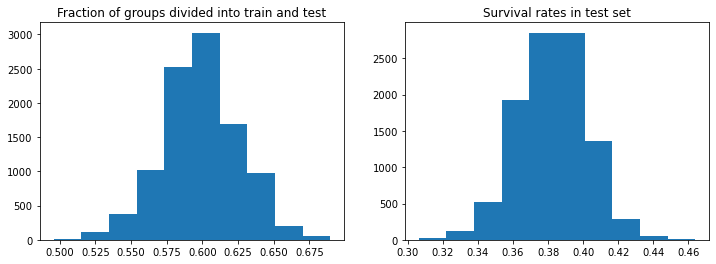

In [12]:
#collapse-hide
overlaps = []
survival_rates = []
N = 10**4

for _ in range(N):
    groups_shuffled = groups.sample(frac=1).reset_index(drop=True)
    train_groups = set(groups_shuffled[kaggle_train_idx].values)
    test_groups = set(groups_shuffled[kaggle_test_idx].values)
    overlap = len(train_groups & test_groups) / n_groups
    overlaps.append(overlap)
    y_shuffled = y.sample(frac=1).reset_index(drop=True)
    survival_rate = y_shuffled[kaggle_test_idx].mean()
    survival_rates.append(survival_rate)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 4))
    
ax0.set_title('Fraction of groups divided into train and test')
ax0.hist(overlaps);

ax1.set_title('Survival rates in test set')
ax1.hist(survival_rates);

The Kaggle test set seems to be very typical, at least as far as the survival rate and passenger groups are concerned. In fact, both values (0.61 and 0.38) are close to the mean for both distributions (almost suspiciously close). This suggests that the test set was either drawn at random or specifically chosen to have a typical survival rate.